# 1. Exploratory Data Analysis (EDA)

Table of contents:
- [1.1 Prerequisites](#1)
- [1.2 Load raw data](#2)
- [1.3 Explore available columns](#3)
   - [1.3.1 Common columns](#3_1)
   - [1.3.2 Correspondence of named columns](#3_2)
   - [1.3.3 Define state names for FIPS codes](#3_3)
   - [1.3.4 Check for null values and incomplete traffic data](#3_4)
   - [1.3.5 Check for null values and incorrect data in traffic stations](#3_5)
- [1.4 Temporal analysis](#4)
   - [1.4.1 Daily and hourly traffic volume patterns](#4_1)
   - [1.4.2 Traffic trends during parts of a day](#4_2)
   - [1.4.3 Traffic trends during day of week](#4_3)
   - [1.4.4 Statistical tests](#4_4)
- [1.5 Spatial analysis](#5)
- [1.6 EDA Summary](#6)

<a id="1"></a>

## 1.1 Prerequisites

Import required libraries. Before running the notebook, it is assumed that the user has already installed the required libraries contained in *requirements.txt* .

In [1]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import pylab
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm

# Modify to adjust figure sizes
pylab.rcParams['figure.figsize'] = (12, 4)

Since the notebooks and utility functions are under src folder of the repository, `os.chdir("..")` is used as an easy way to move back one directory to access the folders. This serves as a workaround for the initial exploration. 

In [2]:
os.chdir("..")
from utils.config import filenames 
from utils import datautils

<a id="2"></a>

## 1.2 Load raw data

Modify the DATA_LOCATION directory as needed. This configuration sets it as src/data in the repository. This assumes that the required data is already located within the directory e.g.
```
us-traffic
│   ...    
│
└───src
|   |   datasetdownloader.py
│   │   ...
│   │
│   └───data  <- (DATA_LOCATION)
|       |    dot_traffic_2015.txt.gz
|       |    dot_traffic_stations_2015.txt.gz
│       |
|       └─── ...
|
...
```

Alternatively, the user can also download the files via the datadownloader.py script under src.

In [3]:
DATA_LOCATION = os.path.join(os.getcwd(), 'data')

There are two main files under the dataset:
- Traffic data - dot_traffic_2015.txt.gz
- Traffic stations data - dot_traffic_stations_2015.txt.gz

In [4]:
traffic_data, traffic_stations = datautils.load_traffic_datasets(
                                                DATA_LOCATION,
                                                filenames["TRAFFIC_DATA"],
                                                filenames["TRAFFIC_STATIONS"])

Loading traffic data from 'dot_traffic_2015.txt.gz' ...
Loading traffic stations from 'dot_traffic_stations_2015.txt.gz' ...
Finished loading data.


<a id="3"></a>

## 1.3 Explore available columns

Upon checking the initial entries for both dataframes, we can see that *traffic_data* mainly contains historical information regarding traffic volume and *traffic_stations* contains the data regarding descriptions of the stations which collected the traffic volume information. 

In [5]:
traffic_data.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,...,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,...,89,122,124,110,69,73,28,12,6,15
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,...,1617,1669,1308,1068,928,885,798,650,613,15
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,...,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,...,1011,959,851,708,559,457,297,207,110,15
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,...,83,61,55,35,29,21,23,9,7,15


In [6]:
print("traffic_data row count:", traffic_data.shape[0])
print("traffic_data column count:", traffic_data.shape[1])

traffic_data row count: 7140391
traffic_data column count: 38


In [7]:
traffic_stations.head()

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,...,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,...,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,...,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,...,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,W01136,E. of Franklin Rd Underpass,L,Inductance loop,15,0,95


In [8]:
print("traffic_stations row count:", traffic_stations.shape[0])
print("traffic_stations column count:", traffic_stations.shape[1])

traffic_stations row count: 28466
traffic_stations column count: 55


<a id="3_1"></a>

### 1.3.1 Common columns

By checking the columns, we can see that there are some common columns for both *traffic_data* and *traffic_stations*. We can use the common columns to match relevant features (e.g. spatial information) from *traffic_stations* to *traffic_data* entries when we do preprocessing for model input later on.

In [9]:
common_cols = set(traffic_data.columns) & set(traffic_stations.columns)
common_cols

{'direction_of_travel',
 'direction_of_travel_name',
 'fips_state_code',
 'functional_classification',
 'functional_classification_name',
 'lane_of_travel',
 'record_type',
 'station_id',
 'year_of_data'}

While it's possible to match the rows through *station_id* alone, it relies on the assumption that there is a one to one correspondence between a specific location/set of coordinates to a single *station_id*.

This assumption may be proven false below.

In [10]:
sample_station = "000302"
spatial_columns = ["fips_state_code",
                   "fips_county_code",
                   "latitude", "longitude",
                   "functional_classification_name"]
sub_df = traffic_stations[traffic_stations["station_id"] == sample_station]
sub_df = sub_df[spatial_columns + ["station_id"]].drop_duplicates()

display(sub_df)

,fips_state_code,fips_county_code,latitude,longitude,functional_classification_name,station_id
3,49,35,40.516500,111.891520,Urban: Principal Arterial - Interstate,000302
7540,8,35,39.430691,104.966383,Rural: Major Collector,000302
8245,19,47,41.910000,95.228300,Rural: Major Collector,000302
14812,48,29,29.299390,98.628500,Urban: Principal Arterial - Interstate,000302
18605,13,51,32.058600,81.022470,Urban: Principal Arterial - Other,000302


As seen in the sub dataframe above, the *station_id* "000302" is not unique to a specific location and appears across different longitude, latitude, and FIPS codes.

Therefore, to get the most appropriate spatial features for a specific row in *traffic_data* we need to make use of other common columns for matching.

<a id="3_2"></a>

### 1.3.2 Correspondence of named columns

Since there are multiple columns with numerical encoding and named equivalent for both *traffic_data* and *traffic_stations* that indicate the same information (e.g. *direction_of_travel* and *direction_of_travel_name*), we can check the assignment and validate if the numerical encoding is unique to each value.

In [11]:
def check_correspondence(df, col1_name, col2_name):
    for var1 in df[col1_name].unique():
        var2 = df[df[col1_name] == var1][col2_name].unique()
        print(var1, var2)

It can be seen that there are no repeated entries except for "Other lanes" in *lane_of_travel_name*. However it is still valid as the multiple entries under "Other lanes" only appear under it and not for the other travel lane names.

Therefore, we can opt to just retrieve the columns with "_name" and perform encoding before modeling.

In [12]:
name_cols = []
for col in set(traffic_data.columns) | set(traffic_stations.columns):
    if "name" in col:
        name_cols.append(col)
        
for col in name_cols:
    print(col, ":")
    check_correspondence(traffic_stations, 
                         col,
                         col[:-5])
    print("--")

functional_classification_name :
Urban: Principal Arterial - Other Freeways or Expressways ['2U']
Rural: Principal Arterial - Other ['3R']
Rural: Principal Arterial - Interstate ['1R']
Urban: Principal Arterial - Interstate ['1U']
Urban: Principal Arterial - Other ['3U']
Rural: Minor Arterial ['4R']
Urban: Minor Arterial ['4U']
Urban: Collector ['5U']
Rural: Major Collector ['5R']
Rural: Minor Collector ['6R']
Urban: Local System ['7U']
Rural: Local System ['7R']
--
direction_of_travel_name :
West [7]
South [5]
North [1]
East [3]
North-South or Northeast-Southwest combined (ATR stations only) [9]
East-West or Southeast-Northwest combined (ATR stations only) [0]
Northeast [2]
Southwest [6]
Northwest [8]
Southeast [4]
--
lane_of_travel_name :
Other lanes [4 2 3 6 5 7 8 9]
Outside (rightmost) lane [1]
Data with lanes combined [0]
--
method_of_vehicle_classification_name :
nan []
Permanent vehicle classification device [3]
Portable vehicle classification device [2]
Human observation (manua

<a id="3_3"></a>

### 1.3.3 Define state names for available FIPS codes

The numbers under *fips_state_code* correspond to [state names in the US](https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm). External information from government sites in US were retrieved to further understand FIPS data present in the dataset. We can check the states along with the number of entries under *traffic_data*. 

We retrieve and process the following dataframes for reference:
- fips_df - Reference containing fips_state_code and state name
- fips_loc_df - Approximate latitude and longitude information per state to validate values in the dataset.

In [13]:
row_dist = dict(traffic_data["fips_state_code"].value_counts())

In [14]:
fips_df, fips_loc_df = datautils.load_other_datasets(DATA_LOCATION,
                                                    filenames["FIPS_CODE"],
                                                    filenames["FIPS_LOC"])

Loading FIPS state codes reference from 'fips_code.csv' ...
Loading approximate FIPS coordinates reference from 'fips_latlong.csv' ...
Finished loading data.


In [15]:
fips_state_ref = datautils.create_fips_ref(fips_df)

In [16]:
state_dist_df = pd.DataFrame(row_dist.items(), columns=["fips_state_code", 
                                                        "entries"])
state_dist_df["state_name"] = [fips_state_ref[fips] for 
                               fips in row_dist.keys()]

In [17]:
state_dist_df.sort_values(by=["entries"], ascending=False, inplace=True)
state_dist_df

,fips_state_code,entries,state_name
0,12,606310,florida
1,51,488559,virginia
2,39,456486,ohio
3,13,355938,georgia
4,55,298473,wisconsin
5,53,266675,washington
6,16,252638,idaho
7,36,247120,new york
8,40,202750,oklahoma
9,28,194908,mississippi


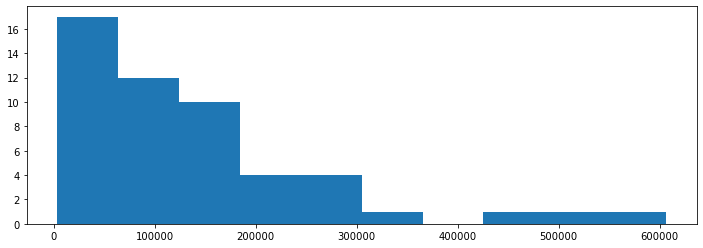

In [18]:
plt.hist(row_dist.values(), bins=10)
plt.show()

<a id="3_4"></a>

### 1.3.4 Check for null values and incomplete data in traffic data

In [19]:
temporal_cols = ['date', 'day_of_data', 'day_of_week', 'month_of_data', 'year_of_data']
data_collection_cols = ['direction_of_travel_name',
                        'fips_state_code',
                        'functional_classification_name',
                        'lane_of_travel', 'record_type',
                        'restrictions', 'station_id']
traffic_vol_cols = [col for col in traffic_data.columns if 'traffic_volume' in col]

In [20]:
print("Null values for traffic volume in traffic_stations:",
      traffic_data[traffic_vol_cols].isnull().sum().sum())

Null values for traffic volume in traffic_stations: 0


In [21]:
print("Null values for temporal columns in traffic_stations:",
      traffic_data[temporal_cols].isnull().sum().sum())

Null values for temporal columns in traffic_stations: 0


In [22]:
print("Null values for temporal columns in traffic_stations:")
print(traffic_data[data_collection_cols].isnull().sum())

Null values for temporal columns in traffic_stations:
direction_of_travel_name                0
fips_state_code                         0
functional_classification_name          0
lane_of_travel                          0
record_type                             0
restrictions                      7140391
station_id                              0
dtype: int64


Since restrictions are just full of NaN columns and isn't a common column between *traffic_data* and *traffic_stations*, we can opt to drop/disregard it.

In [23]:
traffic_data["restrictions"].unique()

array([nan])

Check a sample state to check if the stations collect data for all the dates in the given year of 2015.

In [24]:
sub_state_df = traffic_data[traffic_data["fips_state_code"] == 9]

From this we can see that there are multiple entries per station in a given state. This is due to the direction of travel from the data collected. Since we are only interested in the collective traffic volume collected by the station in a specific location for a given time, we can compress the traffic volume later on by getting the sum.

In [25]:
sub_state_df = sub_state_df[sub_state_df["station_id"] == "009024"]
sub_state_df.sort_values(by="date")[["date",
                          "direction_of_travel_name",
                          "station_id"]]

,date,direction_of_travel_name,station_id
4472009,2015-01-01,West,009024
1290861,2015-01-01,East,009024
2646296,2015-01-02,West,009024
1269220,2015-01-02,East,009024
901436,2015-01-03,East,009024
...,...,...,...
3654540,2015-12-29,East,009024
5947767,2015-12-30,East,009024
2670560,2015-12-30,West,009024
4686220,2015-12-31,East,009024


For now, we can retrieve the unique dates regardless of direction of travel to get the dates where the station collected data in a given state. This is to see if there are gaps in the data. Since a 1 day gap would result in 24 data points lost, it would be hard to supplement the gap with a linear/average approximation due to the inherent seasonality of the data. However it would be possible to fill the gaps if the forecasting to be done is daily.

We can then adjust the approach when transforming the data as model input.

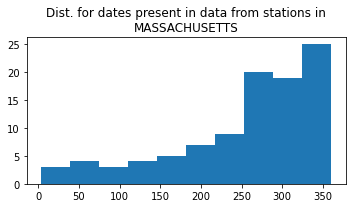

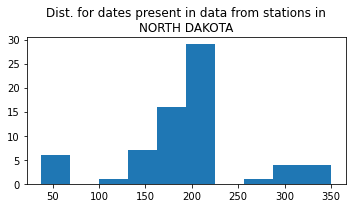

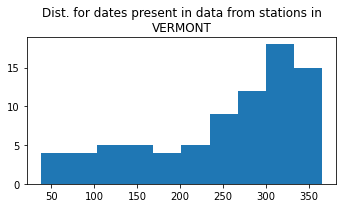

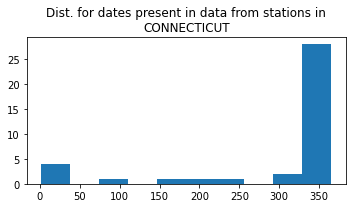

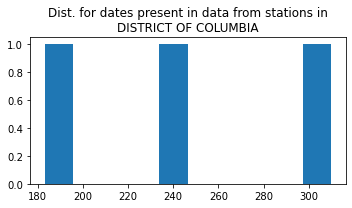

In [26]:
# Possible to supplement with entire list of FIPS state codes
# Displayed distribution for states with least amount of total entries
codes = state_dist_df[-5:]["fips_state_code"]

for fips_state_code in codes:

    state_name = fips_state_ref[fips_state_code].upper()
    sub_state_df = traffic_data[traffic_data["fips_state_code"] == 
                                fips_state_code]

    num_data_points = []
    stations = sub_state_df["station_id"].unique()
    for station_id in stations:
        entries = sub_state_df[sub_state_df["station_id"] == 
                               station_id]["date"].unique().shape[0]
        num_data_points.append(entries)

    plt.figure(figsize=(5,3))
    plt.hist(num_data_points, bins = 10)
    title = f"Dist. for dates present in data from stations in\n{state_name}"
    plt.title(title)
    plt.tight_layout()
    plt.show()

<a id="3_5"></a>

### 1.3.5 Check for null values and incorrect data in traffic stations

If we check a portion of *traffic_stations*, there are a lot of null values but since we're mainly interested in analyzing traffic volume for the data, data from *traffic_stations* is mostly used to supplement our findings and add features for modeling. By checking the spatial columns, we narrow down the features we want to explore for now and note the other columns for future exploration.

In [27]:
print("Null values for temporal columns in traffic_stations:")
null_count_trafficstations = traffic_stations[spatial_columns].isnull().sum()
print(null_count_trafficstations)

Null values for temporal columns in traffic_stations:
fips_state_code                   0
fips_county_code                  0
latitude                          1
longitude                         1
functional_classification_name    0
dtype: int64


Look for the row with the null longitude and latitude entry.

In [28]:
null_row = traffic_stations[traffic_stations[["longitude",
                                              "latitude"]].isna().any(axis=1)]

In [29]:
null_row[["station_id", "station_location", "fips_state_code"]]

,station_id,station_location,fips_state_code
21473,000034,Montgomery on Madison Ave.,1


In [30]:
condition = (traffic_stations["station_id"] == "000034") & \
            (traffic_stations["fips_state_code"] == 1)
traffic_stations[condition][["latitude", "longitude"]]

,latitude,longitude
4427,32.380392,86.286294
7488,32.380392,86.286294
13223,32.380392,86.286294
17168,32.380392,86.286294
19845,32.380392,86.286294
21473,NaN,NaN


Correct the longitude and latitude.

In [31]:
traffic_stations.loc[21473,"latitude"] = 32.380392
traffic_stations.loc[21473,"longitude"] = 86.286294

We assume that 0 entries throughout the dataset is normal since we know that there may be certain areas with lower traffic compared to urban or high density locations.

In [32]:
traffic_data[traffic_vol_cols].describe()

,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,...,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400
count,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,...,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06
mean,1.145878e+02,7.874558e+01,6.622503e+01,7.016138e+01,1.171851e+02,2.454065e+02,4.334301e+02,5.833799e+02,5.774976e+02,5.600694e+02,...,7.009825e+02,7.497160e+02,7.770437e+02,7.565536e+02,6.173322e+02,4.793756e+02,3.906426e+02,3.274747e+02,2.534447e+02,1.798298e+02
std,2.818492e+02,2.202875e+02,2.102642e+02,2.242483e+02,3.227085e+02,5.723301e+02,8.359078e+02,9.984941e+02,9.594217e+02,8.917308e+02,...,1.092236e+03,1.143318e+03,1.173933e+03,1.172116e+03,1.061545e+03,9.203711e+02,8.290271e+02,7.989146e+02,7.284074e+02,6.901713e+02
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.300000e+01,8.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01,2.800000e+01,5.600000e+01,9.000000e+01,1.070000e+02,1.230000e+02,...,1.700000e+02,1.830000e+02,1.860000e+02,1.740000e+02,1.310000e+02,9.500000e+01,7.200000e+01,5.400000e+01,3.600000e+01,2.200000e+01
50%,4.200000e+01,2.700000e+01,2.100000e+01,2.300000e+01,3.800000e+01,8.600000e+01,1.700000e+02,2.640000e+02,2.850000e+02,3.030000e+02,...,4.090000e+02,4.380000e+02,4.520000e+02,4.320000e+02,3.370000e+02,2.520000e+02,1.980000e+02,1.550000e+02,1.090000e+02,7.000000e+01
75%,1.260000e+02,8.500000e+01,7.000000e+01,7.500000e+01,1.180000e+02,2.410000e+02,4.570000e+02,6.570000e+02,6.570000e+02,6.450000e+02,...,8.220000e+02,8.910000e+02,9.340000e+02,9.070000e+02,7.220000e+02,5.510000e+02,4.470000e+02,3.670000e+02,2.780000e+02,1.930000e+02
max,9.999900e+04,8.074100e+04,9.001700e+04,9.001200e+04,7.056000e+04,7.815900e+04,9.002000e+04,9.018700e+04,9.999900e+04,9.530000e+04,...,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04,9.999900e+04


At first glance, we can already see that there are anomalous entries in the dataset since there are entries with 0 longitude and latitude and even a ~990 entry for longitude. For reference, a quick google search would show that the coordinates for the US is 37.0902° N, 95.7129° W. 

In [33]:
traffic_stations[["latitude", "longitude"]].describe()

,latitude,longitude
count,28466.000000,28466.000000
mean,38.140872,100.190810
std,7.423779,77.899394
min,0.000000,0.000000
25%,34.052574,80.576670
50%,39.302096,88.209350
75%,42.252370,111.937942
max,99.900010,993.387110


In [34]:
import folium
from IPython.display import HTML

def visualize_stations(fips_state_code, lat=None, long=None, zoom=6, long_neg=True, 
                       to_display=True, to_save=False, save_dir=None):
    if long_neg == True:
        multiplier = -1
    else:
        multiplier = 1

    if lat == None or long == None:
        lat, long = get_latlong(fips_loc_df, fips_state_code)
    sub_df = traffic_stations[traffic_stations["fips_state_code"] == 
                          fips_state_code]
    m = folium.Map(location=[lat, long*multiplier],
                   zoom_start=zoom)

    sub_df.apply(lambda row:folium.CircleMarker(location=[row["latitude"],
                                                row["longitude"]*multiplier], 
                                                radius=2, color="red", 
                                                popup=(row["station_id"],
                                                       row["latitude"],
                                                       row["longitude"])).add_to(m), axis=1)    
    if to_display:
        display(m)
    if to_save:
        m.save(os.path.join(save_dir, f"{fips_state_code}.html"))

def get_latlong(latlong_df, fips_state_code):
    row = latlong_df[latlong_df["fips_code"] == fips_state_code]
    return row["latitude"].item(), row["longitude"].item()


From the plots below, we can see that some entries for the stations are located outside of the US. There seems to be a common pattern wherein the offset is off by 1 tens place (e.g. 987 should be 98.7 relative to the coordinates of the US).

In [35]:
visualize_stations(fips_state_code=46,
                   lat=44.067112,
                   long=987.602740,
                   zoom=4)

In [36]:
visualize_stations(fips_state_code=10,
                   lat=38.468950,
                   long=7.555783,
                   zoom=6)

Correct zero columns by retrieving the average longitude and latitude to supplement rows with no values.

In [37]:
def get_loc_mask(df, value=0):
    mask = (df["latitude"] == 0) | \
                (df["longitude"] == 0)
    return mask

In [38]:
traffic_stations[["latitude","longitude"]].isin([0]).sum()

latitude     357
longitude    355
dtype: int64

In [39]:
sub_cols = spatial_columns + ["station_location", "station_id"]
zero_df = traffic_stations[get_loc_mask(traffic_stations)][sub_cols]

In [40]:
for state in tqdm(zero_df["fips_state_code"].unique()):

    # Assign longitude and latitude values of closest stations 
    # (same fips and county) to zero values
    ts_sub_df =  traffic_stations[(traffic_stations["fips_state_code"] == state)]
    ts_sub_df = ts_sub_df[sub_cols]
    zero_sub_df = ts_sub_df[get_loc_mask(ts_sub_df)]

    avg_loc = fips_loc_df[fips_loc_df["fips_code"] == state]

    for county in zero_sub_df["fips_county_code"].unique():
        county_df = ts_sub_df[ts_sub_df["fips_county_code"] == county]
        nonzero_count = (county_df.shape[0] - county_df[["latitude",
                          "longitude"]].isin([0]).sum().max())
        if nonzero_count != 0:
            avg_lat = county_df["latitude"].sum()/nonzero_count
            avg_long = county_df["longitude"].sum()/nonzero_count
        else:
            avg_lat = avg_loc["latitude"].item()
            avg_long = avg_loc["longitude"].item()

        zero_rows = county_df[get_loc_mask(county_df)].index

        # Correct zero coordinates
        traffic_stations.loc[zero_rows,"latitude"] = avg_lat
        traffic_stations.loc[zero_rows,"longitude"] = avg_long

In [41]:
traffic_stations[["latitude", "longitude"]].describe()

,latitude,longitude
count,28466.000000,28466.000000
mean,38.653558,101.208962
std,6.064388,77.126073
min,4.151080,6.832740
25%,34.155322,80.758000
50%,39.463549,88.321659
75%,42.305418,111.949251
max,99.900010,993.387110


In [42]:
fips_loc_df.describe()

,fips_code,latitude,longitude
count,55.000000,55.000000,55.000000
mean,31.872727,37.801189,94.592671
std,18.589179,8.726122,22.755662
min,1.000000,13.444300,64.896300
25%,17.500000,34.763850,77.925700
50%,31.000000,39.045800,89.398500
75%,45.500000,42.741600,105.826100
max,78.000000,64.200800,170.132200


Correct the incorrect offset for the longitude and latitude entries.

In [43]:
condition = (traffic_stations["latitude"] < 20)
traffic_stations.loc[condition, "latitude"] *= 10

In [44]:
condition = (traffic_stations["latitude"] > 200)
traffic_stations.loc[condition, "latitude"] /= 10

In [45]:
condition = (traffic_stations["longitude"] < 20)
traffic_stations.loc[condition, "longitude"] *= 10

In [46]:
condition = (traffic_stations["longitude"] > 200)
traffic_stations.loc[condition, "longitude"] /= 10

In [47]:
visualize_stations(fips_state_code=10, zoom=7)

We can see here that while most of the station IDs are proprerly inside of South Dakota, there are still some misplaced stations. We can click on the circles on the map to check the details of these stations. One of the stations "000014" is located somewhere in Montreal. Since we are unsure of the proper offset for these set of values, we can apply thresholding based on the coordinates in *fips_loc_df* later on to disregard entries for these stations due to the nature of the unreliable data.

In [48]:
fips_state_ref[46]

'south dakota'

In [49]:
visualize_stations(fips_state_code=46, zoom=4)

<a id="4"></a>

## 1.4 Temporal analysis

In [50]:
sample_date = traffic_data["date"][0]
print(sample_date, type(sample_date))

2015-04-07 <class 'str'>


Convert date column to datetime.

In [51]:
traffic_data["date"] = pd.to_datetime(traffic_data["date"], format='%Y-%m-%d')

Since there are hourly entries, the scope of the dataset is the entirety of 2015 from January 1, 2015 until December 31, 2015. We can set aside the months of November and December for the test set if we are to do forecasting.

In [52]:
traffic_data["date"].min(), traffic_data["date"].max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [53]:
temporal_cols

['date', 'day_of_data', 'day_of_week', 'month_of_data', 'year_of_data']

Get sum across the hourly traffic volume.

In [54]:
traffic_data["daily_total_traffic_volume"] = traffic_data[traffic_vol_cols].sum(axis=1)

Check behavior across all states.

In [55]:
vol_aggr = traffic_data.groupby(by=["date"]).sum()
vol_aggr.sort_values(by=["date"], inplace=True)

In [56]:
vol_aggr[traffic_vol_cols]

,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,...,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,3223576,3181872,2223664,1575072,1239528,1439760,2031303,2500735,3387267,4676215,...,9983020,9882681,9545403,8820429,7736599,6381873,5312341,4539452,3919722,2886716
2015-01-02,1610246,1217518,1009195,1111719,1763394,3573933,6380159,8984543,9437511,9923855,...,14523395,15008699,15064688,14455224,11640016,9024410,7458470,6374717,5340897,4030416
2015-01-03,2577595,1825768,1455633,1316807,1542949,2250677,3453902,4773896,6416513,8355406,...,12400808,12417839,12085252,11208297,10069097,8174116,6714904,6010771,5220084,3976941
2015-01-04,2453194,1787680,1364075,1073599,1142533,1614966,2395067,3274791,4621344,6524587,...,11763580,11585401,11068517,10103532,8735058,7076017,5986404,4740410,3696621,2625419
2015-01-05,1465199,1022522,898255,1104483,2230505,5124057,9420121,12786833,11690509,9921969,...,12122289,13579024,14592689,14653304,10961416,7795879,5945410,4998290,3832536,3261052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,2746432,1958019,1614357,1346980,1413870,1946702,2842151,3841742,5529217,8067908,...,12820827,12582825,12413939,11728202,10367385,8574065,7025073,5687269,4352633,3056108
2015-12-28,2026581,1445499,1217811,1388296,2410563,5038825,8313180,10492829,10391300,10426716,...,13575288,14256048,14503034,13686523,10364570,7636341,6044691,5120364,3993751,2812931
2015-12-29,1879321,1384483,1217424,1388979,2316712,4762246,7986529,10280653,10208252,10192247,...,12548751,13738041,14644379,14114836,10928467,8191586,6512636,5610674,4426930,3102064


<a id="4_1"></a>

### 1.4.1 Daily and hourly traffic volume patterns

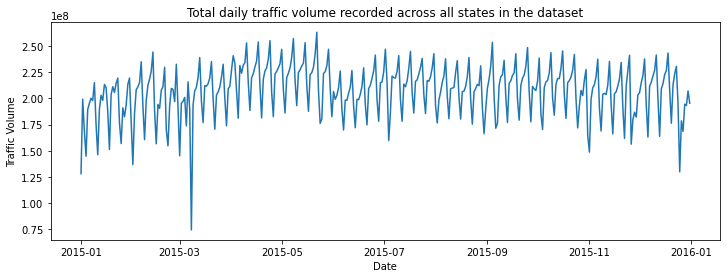

In [57]:
plt.plot(vol_aggr["daily_total_traffic_volume"])
plt.title("Total daily traffic volume recorded across \
all states in the dataset")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.show()

Check the date/entry with the sudden dip.

In [58]:
vol_aggr[vol_aggr["daily_total_traffic_volume"] < 1e8]

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,record_type,restrictions,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,...,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data,daily_total_traffic_volume
date,,,,,,,,,,,,,,,,,,,,,
2015-03-08,59488,7436,29772,232223,8045,22308,22308,0.0,1230385,780863,...,5711736,5294911,4651611,3909009,3114447,2367735,1672892,1008443,111540,74339394


Retrieves hourly rows and transforms it into a 1D array.

In [59]:
hourly_vol_aggr = vol_aggr[traffic_vol_cols].to_numpy().ravel()
hourly_vol_aggr.shape

(8760,)

In [60]:
timestamps = []
hour_delta = [np.timedelta64(hour, 'h') for hour in range(0, 24)]
dates = list(vol_aggr.index)

for date in dates:
    # Apply hour offset in date
    timestamps += [date + hour for hour in hour_delta]

In [61]:
hourly_aggr_df = pd.DataFrame()
hourly_aggr_df["traffic_volume_aggr"] = hourly_vol_aggr
hourly_aggr_df.index = timestamps

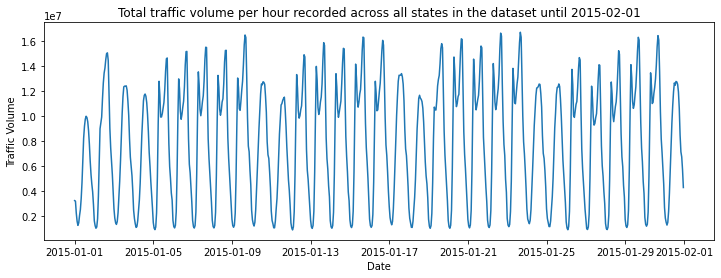

In [62]:
date_limit = "2015-02-01"
plt.plot(hourly_aggr_df[hourly_aggr_df.index < date_limit])
plt.title(f"Total traffic volume per hour recorded across all \
states in the dataset until {date_limit}")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.show()

<a id="4_2"></a>

### 1.4.2 Traffic trends during parts of a day

Graphs per hour for each day in January 2015 are superimposed. It can be seen that there appears to be common trends per hour. 

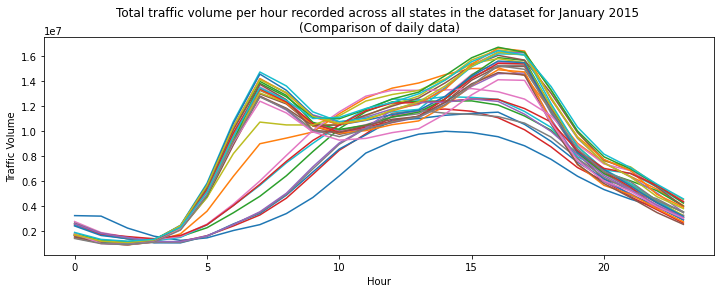

In [63]:
date_limit = "2015-01-" # Can be modified

for i in range(1,31):
    lower_bound = date_limit + str(i).zfill(2)
    upper_bound = date_limit + str(i+1).zfill(2)
    plt.plot(hourly_aggr_df[(lower_bound <= hourly_aggr_df.index) & 
                            (hourly_aggr_df.index < upper_bound)].values)
plt.title(f"Total traffic volume per hour recorded across all \
states in the dataset for January 2015 \n(Comparison of daily data)")
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.show()

During different parts of the day, the trends for the traffic volume differs e.g. for hours during midnight to early morning (0-5AM), it can be seen that the traffic is low since most human activities such as regular office hours and school occur during morning to afternoon. This can be further verified by seeing the spike in traffic volume around midmornings (7-9AM) wherein public transportation such as buses/taxis and private vehicles are being used to go to [schools](https://www.ciee.org/typical-day-school), [business establishments, offices](https://htir.com/articles/business-hours.php), and others.

After stable traffic volumes during early afternoon (11AM-3PM), there are sudden spikes as people most likely return home after their time outside and slowly winding down further as it goes on to the night.

Because of this, we can add parts of day as a feature for our models when forecasting the data.

<a id="4_3"></a>

### 1.4.3 Traffic trends during day of week

Since the day of week values in the dataset are encoded numerically, we can check the named equivalent for the day of week as shown below.

In [64]:
day_of_week_ref = dict()
for day in sorted(traffic_data["day_of_week"].unique()):
    sample = traffic_data[traffic_data["day_of_week"] == day].iloc[0]
    day_name = sample["date"].strftime('%A')
    idx = sample["day_of_week"]

    print("Date: ", sample["date"])
    print("Day: ", day_name)
    print("Day of week value: ", idx, end="\n\n")

    day_of_week_ref[idx] = day_name

Date:  2015-04-26 00:00:00
Day:  Sunday
Day of week value:  1

Date:  2015-11-23 00:00:00
Day:  Monday
Day of week value:  2

Date:  2015-04-07 00:00:00
Day:  Tuesday
Day of week value:  3

Date:  2015-02-18 00:00:00
Day:  Wednesday
Day of week value:  4

Date:  2015-09-10 00:00:00
Day:  Thursday
Day of week value:  5

Date:  2015-06-26 00:00:00
Day:  Friday
Day of week value:  6

Date:  2015-09-26 00:00:00
Day:  Saturday
Day of week value:  7



In [65]:
dow_vol_aggr = traffic_data.groupby(by=["day_of_week"]).mean()

From the plot below we can see that the traffic volume for weekends (Sunday and Saturday) are lower compared to their weekday counterparts. Additionally, there seems to be a slightly higher volume during Friday.

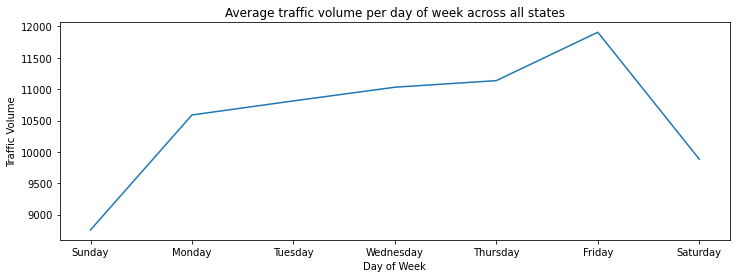

In [66]:
x = [day_of_week_ref[idx] for idx in dow_vol_aggr.index]
plt.plot(x, dow_vol_aggr["daily_total_traffic_volume"])
plt.xlabel("Day of Week")
plt.ylabel("Traffic Volume")
plt.title("Average traffic volume per day of week across all states")
plt.show()

We can further check the behavior of the traffic volume per hour during the day of week. We can see here that there is a significantly lower traffic volume during early mornings during the weekend. This may be attributed to activities such as schools and regular office hours only occuring during the weekdays, thus lowering the traffic volume during weekends.

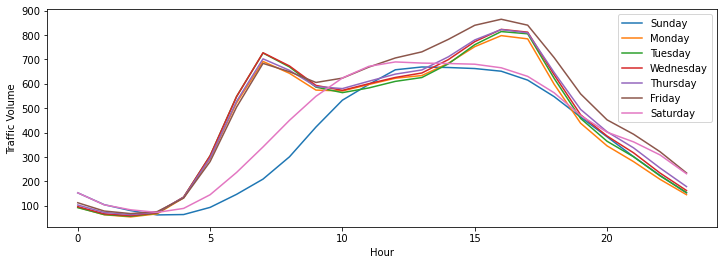

In [67]:
x = range(0, 24)
for idx in dow_vol_aggr.index:
    plt.plot(x, dow_vol_aggr[traffic_vol_cols].loc[idx],
             label=day_of_week_ref[idx])
plt.legend()
plt.xlabel("Hour")
plt.ylabel("Traffic Volume")
plt.show()

<a id="4_4"></a>

### 1.4.4 Statistical tests

Use [Augmented Dickey Fuller test](https://www.statisticshowto.com/adf-augmented-dickey-fuller-test/) to check [for stationarity](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/) for the data. If the p-value is relatively low, we can opt to not transform the data further prior to modeling.

In [68]:
def adf_test(values):
    adf = adfuller(values, autolag='AIC')
    adf_output = pd.Series(adf[1:3], index=["p-value", "Number of lags used"])
    adf_output["ADF Test Statistic"] = adf[0]

    for percent, val in adf[4].items():
        adf_output[f"Critical value {percent}"] = val

    return adf_output

In [69]:
def get_hourly_volume(traffic_volume, date_entries):
    hourly_vol = traffic_volume.to_numpy().ravel()

    timestamps = []
    hour_delta = [np.timedelta64(hour, 'h') for hour in range(0, 24)]
    dates = list(date_entries)

    for date in dates:
        # Apply hour offset in date
        timestamps += [date + hour for hour in hour_delta]

    hourly_df = pd.DataFrame()
    hourly_df["traffic_volume_aggr"] = hourly_vol
    hourly_df.index = timestamps
    
    return hourly_df

In [70]:
adf_test(hourly_aggr_df)

p-value                2.201661e-24
Number of lags used    3.700000e+01
ADF Test Statistic    -1.304494e+01
Critical value 1%     -3.431100e+00
Critical value 5%     -2.861871e+00
Critical value 10%    -2.566946e+00
dtype: float64

In [71]:
adf_test(vol_aggr["daily_total_traffic_volume"])

p-value                 0.128263
Number of lags used    14.000000
ADF Test Statistic     -2.449449
Critical value 1%      -3.449173
Critical value 5%      -2.869833
Critical value 10%     -2.571188
dtype: float64

Modify the parameters below as needed for analysis.

In [72]:
fips_state_code = 12
station_id = "930198"

In [73]:
traffic_data[traffic_data["fips_state_code"] == 
             fips_state_code]["station_id"].value_counts()

930198    8640
930174    8364
140190    5776
930101    5318
150302    5082
          ... 
170361     489
109926     405
570385     112
290320     102
860377      76
Name: station_id, Length: 274, dtype: int64

In [74]:
sub_df = traffic_data[(traffic_data["fips_state_code"] == fips_state_code) & 
                      (traffic_data["station_id"] == station_id)]

In [75]:
sub_df_aggr = sub_df.groupby(by=["date"]).sum()

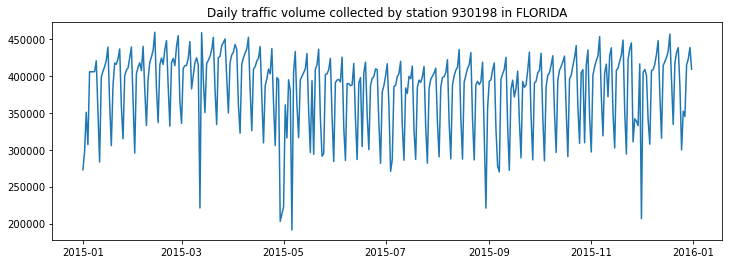

In [76]:
plt.plot(sub_df_aggr["daily_total_traffic_volume"])

title = f"Daily traffic volume collected by station {station_id} in "
title += fips_state_ref[fips_state_code].upper()

plt.title(title)
plt.show()

In [77]:
adf_test(sub_df_aggr["daily_total_traffic_volume"])

p-value                 0.025923
Number of lags used    13.000000
ADF Test Statistic     -3.108605
Critical value 1%      -3.449173
Critical value 5%      -2.869833
Critical value 10%     -2.571188
dtype: float64

In [78]:
hourly_sub_aggr = get_hourly_volume(sub_df_aggr[traffic_vol_cols], 
                                    sub_df_aggr.index)
adf_test(hourly_sub_aggr)

p-value                2.498210e-25
Number of lags used    3.600000e+01
ADF Test Statistic    -1.354243e+01
Critical value 1%     -3.431102e+00
Critical value 5%     -2.861872e+00
Critical value 10%    -2.566947e+00
dtype: float64

The following plots checks the timeseries decomposition for the hourly traffic volume for the data collected from the given station in the state across a daily period. For *hourly_sub_aggr*, the entries are transformed to be hourly instead of daily.

Based on the default values in this notebook, *hourly_sub_aggr* was collected from station "930198" in the state of Florida (FIPS state code 12).

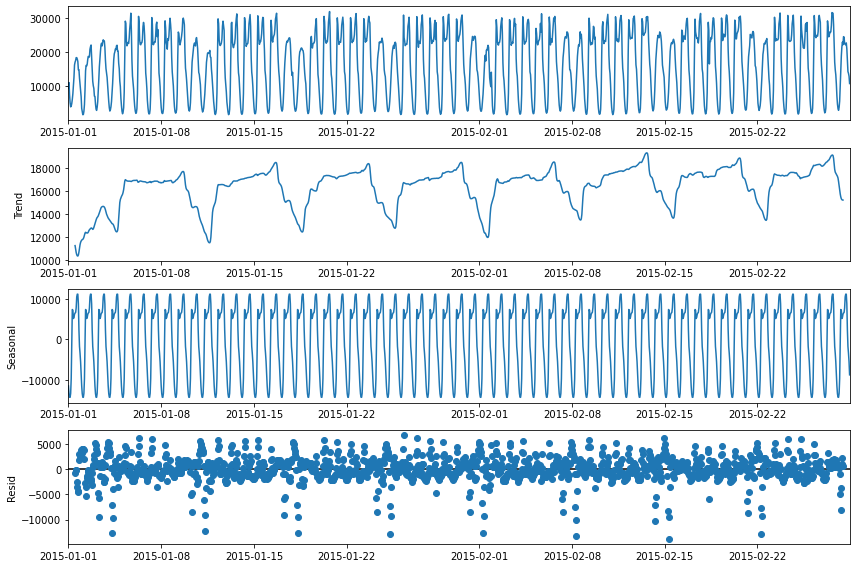

In [79]:
# Can be removed completely/set as 2016-01-01 if to be run for the whole year.
# Limit is placed to make the plots visible.
limit = "2015-03-01"

with mpl.rc_context():
    mpl.rc("figure", figsize=(12,8))
    volume = seasonal_decompose(hourly_sub_aggr[hourly_sub_aggr.index < limit],
                                model='additive',
                                period=24) # hours in the given dataframe
    volume.plot()
    plt.show()

The following shows the timeseries decomposition for the daily total traffic volume to check for trends on a weekly interval. Since the *vol_aggr* has daily entries, the period is set to 7.

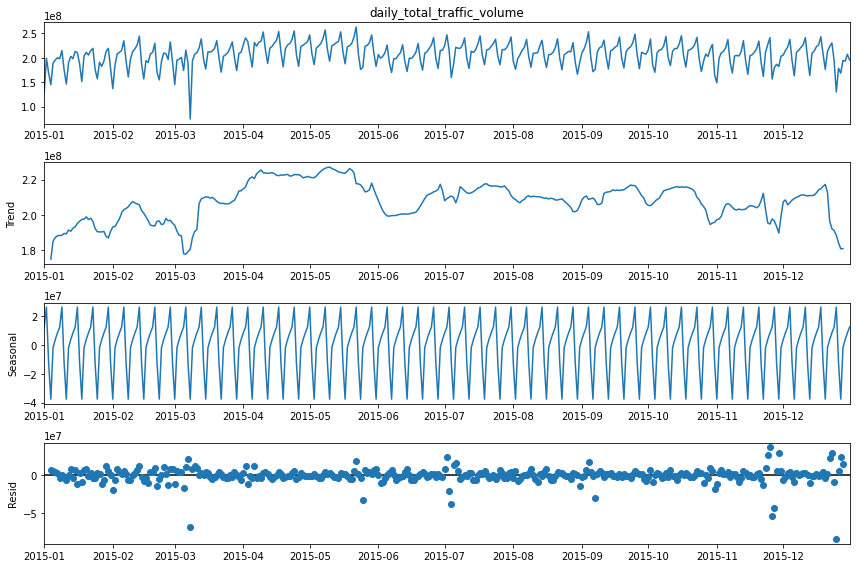

In [80]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,8))
    volume = seasonal_decompose(vol_aggr["daily_total_traffic_volume"],
                                model='additive',
                                period=7)
    volume.plot()
    plt.show()

<a id="5"></a>

## 1.5 Spatial Analysis

<a id="5_1"></a>

### 1.5.1 Module for visualizing stations per state

Create a module for quick checking of station plots across states.

In [81]:
import folium
from IPython.display import HTML, display
import ipywidgets as widgets

dropdown_states = widgets.Dropdown(options = fips_df["state_name"].unique())
frame = widgets.Output()
long_neg=True

def dropdown_states_eventhandler(state):
    frame.clear_output()
    with frame:
        fips_state_code = fips_df[fips_df["state_name"] == 
                                  state.new]["fips_code"].item()

        visualize_stations(fips_state_code, zoom=5)

dropdown_states.observe(dropdown_states_eventhandler, names="value")
display(dropdown_states)
display(frame)

Dropdown(options=('ALASKA', 'ALABAMA', 'ARKANSAS', 'AMERICAN SAMOA', 'ARIZONA', 'CALIFORNIA', 'COLORADO', 'CON…

Output()

<a id="5_2"></a>

### 1.5.2 Average traffic volume per state

In [82]:
state_aggr = traffic_data.groupby(by="fips_state_code")

In [83]:
state_vol_df = pd.DataFrame(dict(state_aggr["daily_total_traffic_volume"].mean()).items(), 
                             columns=["fips_state_code", "avg_daily_traffic_volume"])
state_vol_df["state_name"] = [fips_state_ref[fips] for 
                               fips in row_dist.keys()]



In [84]:
station_per_state = dict(state_aggr["station_id"].unique())
station_count = [len(station_per_state[state]) for state in station_per_state.keys()]

In [85]:
state_vol_df["station_count"] = station_count

There are many possible reasons for high daily traffic volume such as density of population in the state, amount of stations collecting data and coordinates, amount of roads or major highways across the state providing interstate travel, establishments for leisure and providing necessities as well as offices and schools in an area, and many others.

In [86]:
state_vol_df.sort_values(by="avg_daily_traffic_volume", ascending=False)

,fips_state_code,avg_daily_traffic_volume,state_name,station_count
2,4,41975.350252,ohio,275
40,45,35202.631662,new jersey,131
4,6,34912.276425,wisconsin,297
20,24,24873.391630,arizona,73
39,44,23741.895243,tennessee,93
21,25,23640.604401,montana,99
6,9,22781.689851,idaho,38
8,11,20597.728118,oklahoma,3
46,51,18807.749916,massachusetts,781
43,48,17378.775613,south carolina,264


Check correlation between the number of stations in a given state and the average daily traffic volume.

In [87]:
state_vol_df[["station_count","avg_daily_traffic_volume"]].corr()

,station_count,avg_daily_traffic_volume
station_count,1.000000,0.273404
avg_daily_traffic_volume,0.273404,1.000000


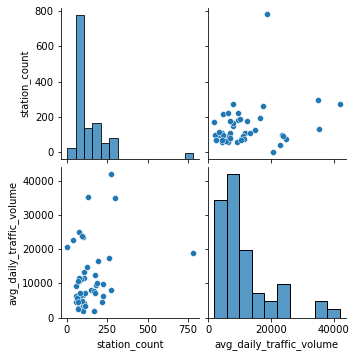

In [88]:
sns.pairplot(state_vol_df[["station_count","avg_daily_traffic_volume"]])
plt.show()

<a id="5_3"></a>

### 1.5.3 Explore relation between average daily traffic volume and coordinate values

In [89]:
# Modify as needed
fips_state_code = 6
comp_cols = ["station_id", "fips_state_code"]

loc_comp_df = traffic_data[traffic_data["fips_state_code"] == 
                         fips_state_code]
loc_comp_df = pd.merge(loc_comp_df, traffic_stations[["station_id"] + spatial_columns], 
                       on=comp_cols)
loc_comp_df = loc_comp_df[["daily_total_traffic_volume",
                          "latitude","longitude"]].drop_duplicates()

In [90]:
print("Num of unique latitude: ", loc_comp_df["latitude"].unique().shape[0])
print("Num of unique longitude: ", loc_comp_df["longitude"].unique().shape[0])

Num of unique latitude:  281
Num of unique longitude:  280


In [91]:
loc_comp_df.corr()["daily_total_traffic_volume"]

daily_total_traffic_volume    1.000000
latitude                     -0.396058
longitude                    -0.252037
Name: daily_total_traffic_volume, dtype: float64

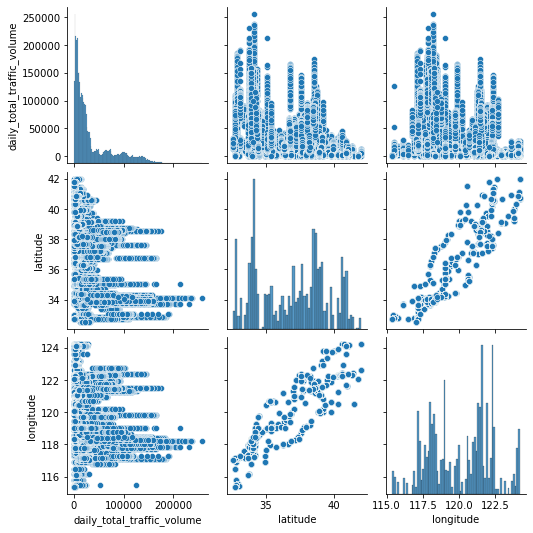

In [92]:
sns.pairplot(loc_comp_df[["daily_total_traffic_volume",
                          "latitude","longitude"]])
plt.show()

<a id="5_4"></a>

### 1.5.4 Traffic volume trends comparison for urban and rural areas

Check highest daily traffic volume across the dataset.

In [93]:
daily_vol_stats = traffic_data["daily_total_traffic_volume"].describe()
daily_vol_stats

count    7.140391e+06
mean     1.059225e+04
std      1.673815e+04
min     -1.400000e+01
25%      2.399000e+03
50%      5.900000e+03
75%      1.237100e+04
max      1.522379e+06
Name: daily_total_traffic_volume, dtype: float64

In [94]:
sub_cols = ["fips_state_code",
            "functional_classification_name",
            "station_id"]
traffic_data[traffic_data["daily_total_traffic_volume"] == 
             daily_vol_stats["max"]][["date"] + sub_cols]

,date,fips_state_code,functional_classification_name,station_id
5643609,2015-05-31,36,Urban: Collector,003480


In [95]:
fips_state_ref[36]

'new york'

In [96]:
traffic_stations[(traffic_stations["fips_state_code"] == 36) &
                 (traffic_stations["station_id"] == "003480")][spatial_columns]

,fips_state_code,fips_county_code,latitude,longitude,functional_classification_name
8822,36,75,43.300598,76.152061,Urban: Collector
26555,36,75,43.300598,76.152061,Urban: Collector


Check the general trend for urban and rural areas.

In [97]:
ur_aggr = traffic_data.groupby(by="functional_classification_name")
ur_comparison = ur_aggr["daily_total_traffic_volume"].mean().sort_values()

We can see here that compared to rural traffic volumes, urban areas typically have higher average traffic volume across all states. However, there are some values such as "Rural: Principal Arterial - Interstate" which has higher average daily traffic volume but is still much lower compared to it's urban counterpart "Urban: Principal Arterial - Interstate"

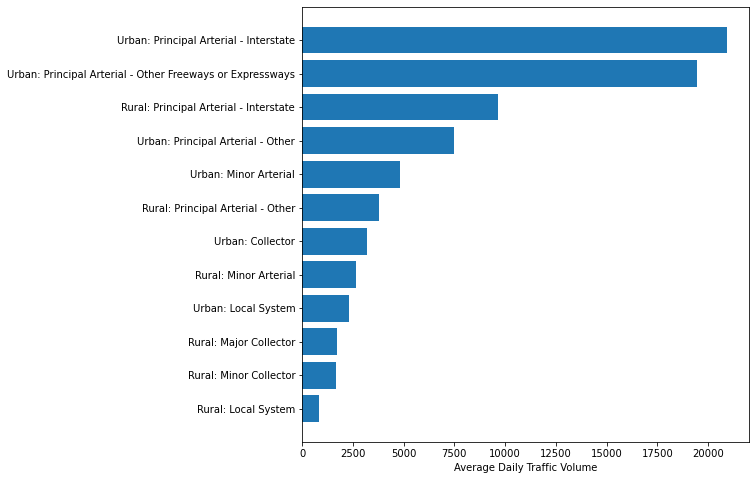

In [98]:
plt.figure(figsize=(8,8))
plt.barh(ur_comparison.index, ur_comparison.values)
plt.xlabel("Average Daily Traffic Volume")
plt.show()

<a id="6"></a>
## 1.6 EDA Summary

During our initial analysis, we can see from the data that there are hourly entries for traffic volume data collected by stations for a given state in the US for the entire year of 2015. Per state, there are counties and more spatial information such as urban vs. rural, longitude, and latitude values. Upon checking the data, there are gaps between daily entries but no null values were found for the hourly entries. While there are 0 and negative values, we assume that the sensors for each station are properly calibrated and leave those values untouched as these values may be intentional per station. We also assume that while stations may have different sensors, the traffic volume data entries are normalized to be of the same unit in the dataset.

While checking the traffic stations, it was seen that there were some entries with common patterns of incorrect longitude and latitude data. This was verified by collecting external data by matching the FIPS state codes to their approximate longitude and latitude. These values were corrected with an offset and it was seen through visualization that these corrected values are more appropriate given their state location. However, it was seen that there are still some stations with anomalous values. Since these values cannot be corrected by a simple multiplier, it is noted that it is possible to leave out these stations during visualization or forecasting due to the unreliable nature of the data. Other incorrect data points were corrected during analysis and some columns were left out since they mostly contained information regarding the stations and often had NaN values--these columns are noted for future exploration.

Afterwards, we check the generalized temporal behavior of the data and see trends regarding hour of day, part of day, day of week. Statistical tests were also applied and it was seen that the p-value of the hourly traffic volume time series data has a low p-value which indicates it being stationary and not needing further pre-processing. However it is noted that the daily time series data for the traffic volume is relatively high so forecasting for daily traffic volume may need pre-processing to adjust these values (e.g. via log).

Lastly, spatial analysis was done by comparing the traffic trends and amount of stations that collected data per state. Traffic volume for states and possible correlation given longitude and latitude values were also explored. It was also confirmed that urban areas have higher daily traffic volume compared to rural areas and may be used as features for modeling.

After our EDA, we can move onto feature engineering and data pre-processing to prepare our time series data for forecasting.